# Example 1: Visualizing a trefoil knot with `kmapper` + `dyneusr` #

## 1 &nbsp;  `import` libraries ##

In [1]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scipy as sp

import networkx as nx
from collections import Counter

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("paper", "white")

%matplotlib inline

### 1.1 &nbsp;  `import kmapper` ###

Here, we will use the KeplerMapper (`kmapper`) implementation of the Mapper algorithm. 

We will also import sklearn implementations of PCA and TSNE to see how these standard (linear and non-linear, respectively) dimensionality reduction tools compare to Mapper.

In [4]:
import kmapper as km
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

### 1.2 &nbsp;  `import dyneusr` ###

Note, all code to generate and visualize a synthetic trefoil knot, used below, is provided by the `dyneusr.datasets` module. 

In [5]:
import dyneusr as ds

# trefoil datasets
from dyneusr.datasets.trefoil import make_trefoil, Bunch
from dyneusr.datasets.trefoil import draw_trefoil3d, draw_trefoil

# visualizing the stages of mapper
from dyneusr.tools.networkx_utils import visualize_mapper_stages

## 2 &nbsp; Load `data` ##

In [6]:
# sample 100 points from the trefoil knot
data = make_trefoil(size=100)

# print some info
print("Dataset (keys):", data.keys())
print("Data has shape:", data.data.shape)

Dataset (keys): dict_keys(['data', 'feature_names', 'target', 'coloring', 'cmap', 'norm', 'index', 'domain'])
Data has shape: (100, 3)


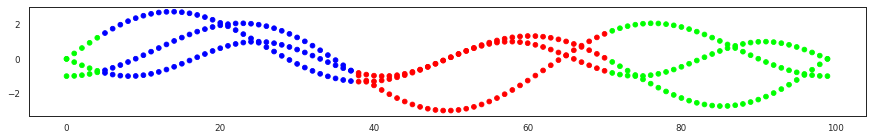

In [7]:
# define inputs: X=data, y=meta
X = data.data
X_inverse = data.data
y = data.target
c = data.coloring

# visualize each dimension of the trefoil knot
fig, axes = plt.subplots(1, 1, figsize=(15, 2))
for i,x in enumerate(X.T):
    plt.scatter(np.arange(x.size), x, c=c)

### 2.1 &nbsp; Visualize the `data` ###

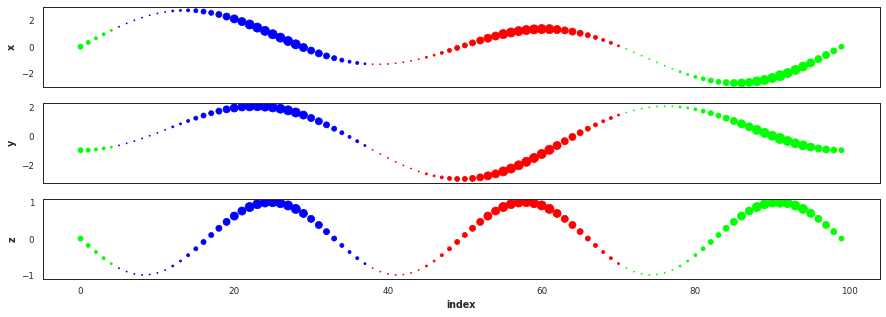

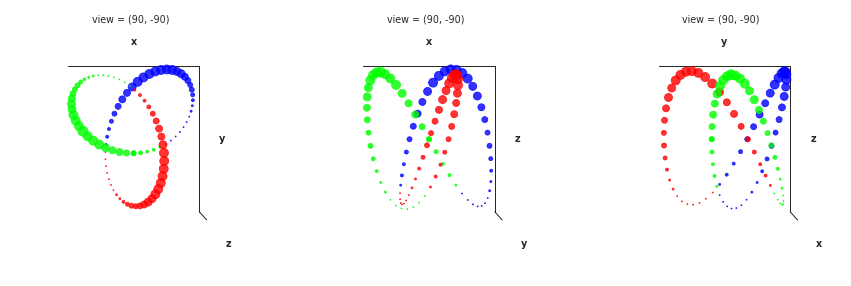

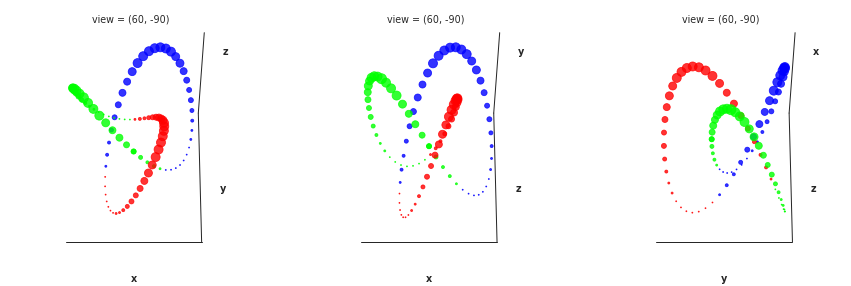

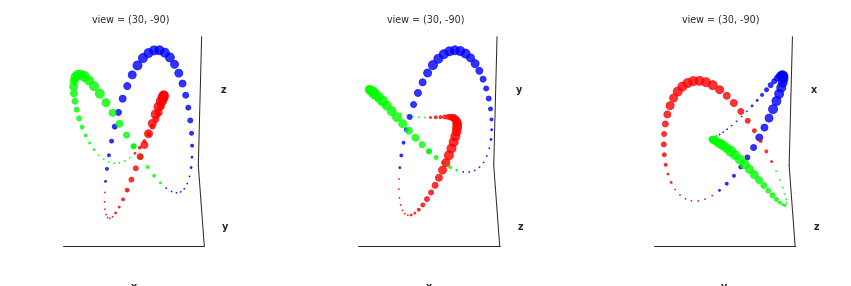

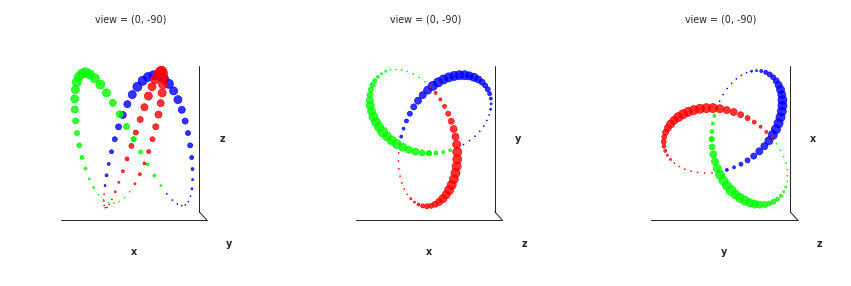

In [8]:
# visualize each dimension of the trefoil knot
_ = draw_trefoil(*data.data.T, c=data.coloring)

# visualize 3D scatter plots of the trefoil knot
_ = draw_trefoil3d(*data.data.T, c=data.coloring)
_ = draw_trefoil3d(*data.data.T, c=data.coloring, view=(60, -90))
_ = draw_trefoil3d(*data.data.T, c=data.coloring, view=(30, -90))
_ = draw_trefoil3d(*data.data.T, c=data.coloring, view=(0, -90))

### 2.2 &nbsp; Visualize projections of the `data` using standard dimensionality reduction tools ###

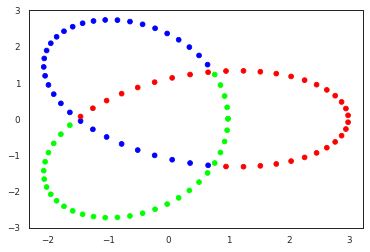

In [9]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(X)

# visualize the projection
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=data.coloring)

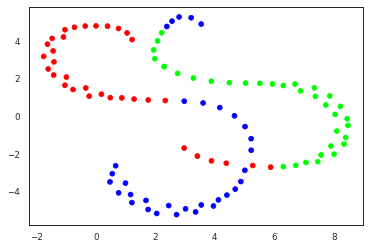

In [10]:
tsne = TSNE(n_components=2, random_state=0)
x_tsne = tsne.fit_transform(X)

# visualize the projection
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=data.coloring)


## 3 &nbsp; Generate a shape graph with `kmapper` ##

In [11]:
# init MAPPER
mapper = km.KeplerMapper(verbose=1)

# define the filter function (i.e., lens or projection)
projection = [0, 1]

# define the clusterer (i.e., for partial clustering in the original space)
clusterer = km.cluster.DBSCAN(eps=1)

# define the cover (i.e,. resolution=#bins, gain=%overlap)
cover = km.Cover(6, 0.5)

KeplerMapper()


In [12]:
# run MAPPER
lens = mapper.fit_transform(X, projection=projection)
graph = mapper.map(lens, X_inverse, clusterer, cover=cover)

# cache the parameters and results for later
mapped = Bunch(X=X, lens=lens, graph=graph, clusterer=clusterer, cover=cover)

..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler(copy=True, feature_range=(0, 1))
..Projecting on data shaped (100, 3)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler(copy=True, feature_range=(0, 1))

Mapping on data shaped (100, 3) using lens shaped (100, 2)

Creating 36 hypercubes.

Created 69 edges and 38 nodes in 0:00:00.043408.


### 3.1 &nbsp; Visualize the `lens` ###

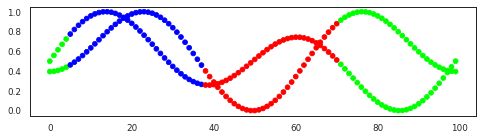

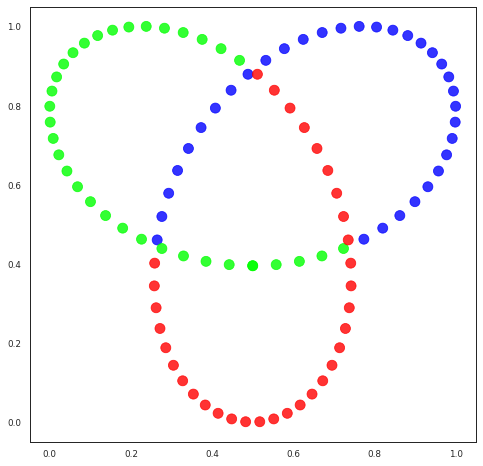

In [13]:
# ensure the lens is 2D
if len(lens.T) < 2:
    lens = np.c_[np.zeros_like(lens), lens] 

# plot 1D view of lens
fig, axes = plt.subplots(1, 1, figsize=(8, 2))
for i,f in enumerate(lens.T):
    plt.scatter(np.arange(f.size), f, c=c, cmap='brg')

# plot 2D view of lens
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(*lens.T, c=c, s=100, alpha=0.8)


## 4 &nbsp; Visualize the shape graph with `dyneusr` ##

In [14]:
# fit a DyNeuGraph to the shape graph
dG = ds.DyNeuGraph(G=graph, y=y)

# show shape of map_ (dimensions: nodes x members)
print(dG.map_.shape)

label,group,value,row_count
meta-column-0,0,314.16,100


(100, 38)


### 4.1 &nbsp; Visualize the stages of the Mapper algorithm ###

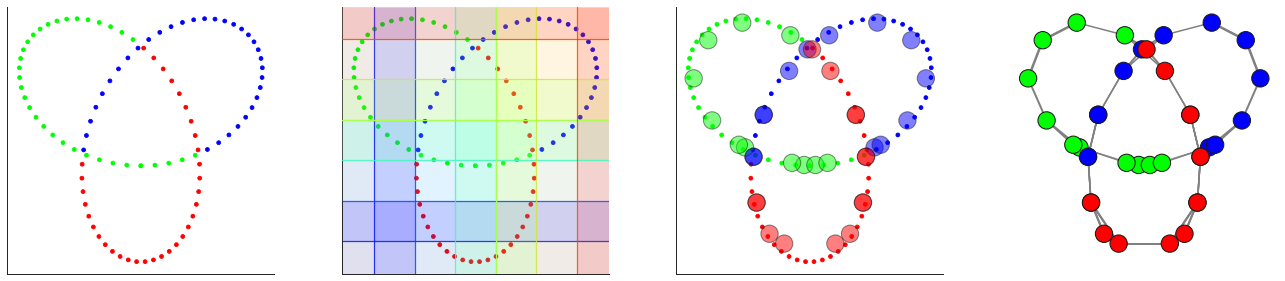

In [15]:
# draw MAPPER stages (and intermediates)
_ = visualize_mapper_stages(data, dG=dG, **mapped, node_size=300, edge_color='gray')

### 4.2 &nbsp; Visualize the shape graph with `networkx` ###

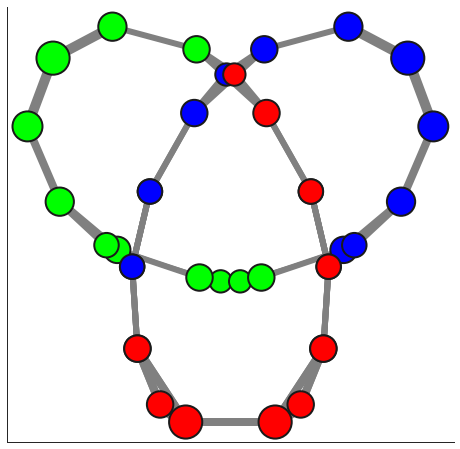

In [16]:
# node color, size
node_size = [100*len(y[_]) for n,_ in dG.G_.nodes(data='members')]
node_color = [Counter(map(mpl.colors.to_hex, c[_])).most_common()[0][0] for n,_ in dG.G_.nodes(data='members')]

# edge color, size
edge_size = [2*_ for u,v,_ in dG.G_.edges(data='size')]
edge_sources = [dG.G_.nodes[u]['members'] for u,v in dG.G_.edges()]
edge_targets = [dG.G_.nodes[v]['members'] for u,v in dG.G_.edges()]
edge_color = None

# plot nx
fig, ax = plt.subplots(1, 1, figsize=(8,8))
_ = ds.tools.networkx_utils.draw_nx(
    dG.G_, lens=lens, pos="inverse", layout=None, ax=ax, 
    node_color=node_color, node_size=node_size, 
    edge_color=edge_color, width=edge_size, 
    )

### 4.3 &nbsp; Visualize the shape graph with `networkx` (using the `kamada_kawai` layout) ###

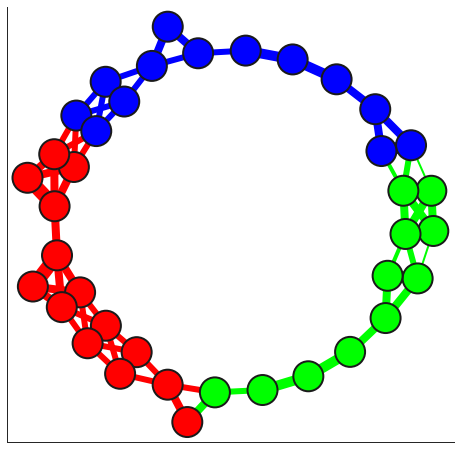

In [17]:
# node color, size
node_size = [900 + 0*len(y[_]) for n,_ in dG.G_.nodes(data='members')]
node_color = [Counter(map(mpl.colors.to_hex, c[_])).most_common()[0][0] for n,_ in dG.G_.nodes(data='members')]

# edge color, size
edge_size = [2*_ for u,v,_ in dG.G_.edges(data='size')]
edge_sources = [dG.G_.nodes[u]['members'] for u,v in dG.G_.edges()]
edge_targets = [dG.G_.nodes[v]['members'] for u,v in dG.G_.edges()]
edge_color = [Counter(map(mpl.colors.to_hex, c[s + t])).most_common()[0][0] 
              for s,t in zip(edge_sources, edge_targets)]

# plot nx
fig, ax = plt.subplots(1, 1, figsize=(8,8))
_ = ds.tools.networkx_utils.draw_nx(
    dG.G_, lens=lens, pos=None, layout='kamada_kawai', ax=ax, 
    node_color=node_color, node_size=node_size, 
    edge_color=edge_color, width=edge_size, 
    )

### 4.4 &nbsp; Visualize the shape graph with `dyneusr` (using the `d3-force` layout) ###

In [ ]:
_ = dG.visualize('dyneusr_output_trefoil_knot.html', show=True, port=8801)